# Instruções Para Executar Este Notebook:
## No Google Colab:
### 1)Descompacte Os Arquivos e Coloque em Um Diretório de Preferência no Seu Computador
### 2)Importe o Arquivo 'Prova_Daedalus_Questao_02.ipynb':
### Clique em Arquivo> Fazer upload de notebook, selecione o arquivo 'Prova_Daedalus_Questao_02.ipynb' no seu computador
### 3)Coloque os Arquivos 'best_model.pth' e 'celebrities.db' dentro do diretório 'content/'
### 4)Execute as Celulas Abaixo Sequindo as Instruções Deste Notebook

## Localmente no Anaconda:
### 1)Descompacte Os Arquivos e Coloque em Um Diretório de Preferência no Seu Computador
### 2)Com o Terminal Entre no Diretório 'Questao_02/' e Execute o Comando: jupyter notebook, clique em 'Prova_Daedalus_Questao_02.ipynb'
### 3)Coloque os Arquivos 'best_model.pth' e 'celebrities.db' dentro do diretório 'Questao_02/'
### 4)Clique no Arquivo 'Prova_Daedalus_Questao_02.ipynb' e Abra no Navegador, Execute as Células Abaixo Sequindo as Instruções Deste Notebook.

# RECONHECIMENTO FACIAL UTILIZANDO FACENET PYTORCH PARA APRENDIZADO DE MÉTRICA

<!DOCTYPE html>
<html>
  <head>
    <link rel="stylesheet" href="styles.css" />
  </head>
  <body>
      <img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/0*n8rkf0rw-1-Xh7i6.png'>
      <script src="script.js"></script>
  </body>
</html>

Para essa prova foi utilizado o framework facenet_pytorch para aprendizado de métrica, utilizando a técnica conhecida como transfer learning, que basicamente consiste em usar uma rede pré-treinada em outro conjunto de dados como ponto de partida, e posteriormante treinar em nossos dados, ou seja, foi utilizada uma rede pré-treinada em um conjunto de dados faciais de várias pessoas diferentes chamada de 'vggface2', posteriormente esse modelo foi treinado no dataset de celebridades fornecido nessa prova para realizar o ajuste fino para esse problema de negócio específico.
Para avaliar o desempenho do modelo foram utilizadas duas métricas, a primeira é a menor distância euclidiana, que mede a distância entre os vetores descritores de cada face, quanto menor melhor pois mais parecidas são as imagens. A segunda é a similaridade do cosseno, que compara os vetores descritores de duas imagens de faces diferentes no espaço de estados, contendo características únicas de cada face, ela varia entre -1 e 1, nesse caso, quanto mais próximo de 1 melhor, pois significa que o grau de similaridade entre as duas imagens é maior.

# Processo de Aprendizado das Rede Neural Siamesa

<!DOCTYPE html>
<html>
  <head>
    <link rel="stylesheet" href="styles.css" />
  </head>
  <body>
      <img src='https://miro.medium.com/v2/resize:fit:640/format:webp/0*571rX51m14sjl084.png'>
      <script src="script.js"></script>
  </body>
</html>

Facenet utiliza a arquitetura Inception ResNet , que combina o módulo Inception com conexões residuais. Essa arquitetura permite que a rede aprenda e gere representações de faces na forma de embeddings numéricos. Esses embeddings são vetores de alta dimensão que representam as características únicas do rosto de uma pessoa. Ao usar a similaridade de cosseno, os sistemas de reconhecimento facial podem determinar se duas faces pertencem à mesma pessoa ou não.

## Instala os Pacotes Necessários

In [1]:
!pip install facenet-pytorch
!pip install torch
!pip install tqdm
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install db-sqlite3
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for db-sqlite3: filename=db_sqlite3-0.0.1-py3-none-any.whl size=1770 sha256=4f5d39e8f7e9c44f87a874891065ddf7c335bc9971a3be73af0482bab9b59d49
  Stored in directory: /root/.cache/pip/wheels/a6/b7/83/e941e0a0e04f417982e718ae7295d1e82b5f2863a1c51edd71
  Created wheel for db: filename=db-0.1.1-py3-none-any.whl size=3875 sha256=a51d589527b856905b6e51cb8fc923f153d2035e9084da02a5a89c5556a1af34
  Stored in directory: /root/.cache/pip/wheels/7d/e4/df/bc55b93af204ab098d9effec76f6889ad12d7ad74e833c4910
  Created wheel for antiorm: filename=ant

## Importa as Bibliotecas e Define Funções Auxiliares Que Serão Utilizadas

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
import gdown
import zipfile
from PIL import Image
from pathlib import Path
import random
import shutil
import sqlite3
from pytorch_metric_learning.distances import CosineSimilarity
import cv2
import io
from tqdm import tqdm
from types import MethodType
from google.colab.patches import cv2_imshow
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"

In [3]:
distance = CosineSimilarity()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize( #normaliza as imagens usando o vetor de medias e desvios padrão
    mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]
)

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def encode(img):
    res = resnet(torch.Tensor(img))
    return res

def show_decision(dist,thres=0.7):
  if dist>=thres:
    print("Mesma Pessoa")
  else:
    print("Pessoa Diferente")

def detect_box(self, img, save_path=None):
    # Detect faces
    batch_boxes, batch_probs, batch_points = self.detect(img, landmarks=True)
    # Select faces
    if not self.keep_all:
        batch_boxes, batch_probs, batch_points = self.select_boxes(
            batch_boxes, batch_probs, batch_points, img, method=self.selection_method
        )
    # Extract faces
    faces = self.extract(img, batch_boxes, save_path)
    return batch_boxes, faces

def checkpoint(model, filename):
  '''função para salvar o modelo'''
  torch.save(model.state_dict(), filename)

def resume(model, filename):
  '''função para carregar o modelo'''
  model.load_state_dict(torch.load(filename))

def create_train_dataset(url):
  '''Cria o dataset de treino, baixando os dados da url '''
  dest="TrainDataset"
  #deleta o diretorio se ele ja existir
  if os.path.isdir(dest):
    shutil.rmtree(dest)
  #Download Dataset
  output = 'dataset.zip'
  gdown.download(url, output, quiet=False)
  #Descompacta o Dataset
  with zipfile.ZipFile("dataset.zip","r") as zip_ref:
      zip_ref.extractall()
  # Renomeia o diretório para os dados de treino
  source="post-processed"
  os.rename(source, dest)
  # configura o diretorio dos dados de treino
  train_data_path = Path(dest)
  # Remove o arquivo dataset.zip
  del_file="dataset.zip"
  os.remove(del_file)
  print('Train Dataset Concluído')
  return train_data_path

def create_test_dataset(url1,url2):
  '''cria o dataset de testes, que serão imagens que o modelo não usará durante o treinamento,
  essas são as duas imagens do Marcelo com máscara e sem máscara'''
  # Cria o diretorio dos dados de teste
  test_dir="TestDataset"
  #deleta o diretorio se ele ja existir
  if os.path.isdir(test_dir):
    shutil.rmtree(test_dir)
  os.mkdir(test_dir)
  # Cria a nova classe Marcelo para testes
  new_class="/Marcelo/"
  #deleta o diretorio se ele ja existir
  if os.path.isdir(test_dir+new_class):
    shutil.rmtree(test_dir+new_class)
  os.mkdir(test_dir+new_class)
  # configura o diretorio dos dados de teste
  test_data_path = Path(test_dir)
  # Faz o download dos dados de teste, da imagem sem máscara
  output1 = 'marcelinho_no_db.jpg'
  gdown.download(url1, test_dir+new_class+output1, quiet=False)

  # Faz o download da imagem do Marcelo com máscara
  output2 = 'marcelinho_na_inferencia.jpg'
  gdown.download(url2, test_dir+new_class+output2, quiet=False)
  #preenche e redimensiona as imagens para o formato 112x112,
  #para que mantenham a proporção original, sem distorcer a imagem
  #fill_resize_img(test_dir,new_class)
  print('Test Dataset Concluído')
  return test_data_path

#define funçoes para salvar imagens no banco sqlite

def convertToBinaryData(filename):
  '''Função para converter dados binários em formato legível por humanos'''
  # Convert binary format to images
  # or files data
  with open(filename, 'rb') as file:
    blobData = file.read()
  return blobData


def insertBLOB(path,vector_des):
  '''Função para criar conexão e inserir os dados no banco SQLite'''
  try:
    # Usa o método connect para estabelecer conexão com o banco sqlite
    sqliteConnection = sqlite3.connect('celebrities.db')
    cursor = sqliteConnection.cursor()
    cursor.execute("CREATE TABLE IF NOT EXISTS famous_person(path, photo, vector_des)")
    print("Conectado a SQLite database celebridades")

    # realiza a query
    sqlite_insert_blob_query = """ INSERT INTO famous_person
                                  (path, photo, vector_des) VALUES (?, ?, ?)"""

    # Converte dados binários em formato legivel para humanos
    photo = convertToBinaryData(path)
    # Converte data no formato de tupla
    data_tuple = (path, photo, vector_des)

    # usa o cursor para executar a query
    cursor.execute(sqlite_insert_blob_query, data_tuple)
    sqliteConnection.commit()
    print("Imagem {} inserida com successo na tabela no BLOB".format(path))
    cursor.close()
  except Exception as e:
     print(e)
     print("Falha ao inserir imagem {} do blob na tabela sqlite, tentando atualizar tabela".format(path))
     sql_update_query = """UPDATE famous_person SET path=?, photo=?, vector_des=?"""
     cursor.execute(sql_update_query, data_tuple)
     sqliteConnection.commit()
     print("Imagem {} atualizada com successo na tabela no BLOB".format(path))
     cursor.close()
  finally:
    if sqliteConnection:
      sqliteConnection.close()
      print("A conexão sqlite está fechada")

## Cria o Dataset de Treino Com Imagens de Celebridades, Para Treinar o Modelo

In [4]:
url = 'https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT&export=download'

global train_data_path
train_data_path=create_train_dataset(url)

Downloading...
From: https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT&export=download
To: /content/dataset.zip
100%|██████████| 71.4M/71.4M [00:02<00:00, 30.4MB/s]


Train Dataset Concluído


## Cria o Dataset de Testes, Com as Duas Imagens do Marcelo, Com e Sem Máscara, Para Avaliar o Desenpenho do Modelo, Obs: Esses Dados Não Serão Usados Durante o Treinamento, Apenas Para Testar o Desempenho Do Modelo

In [5]:
url1 = 'https://drive.google.com/uc?id=1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb&export=download'
url2 = 'https://drive.google.com/uc?id=1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW&export=download'

global test_data_path
test_data_path=create_test_dataset(url1,url2)

Downloading...
From: https://drive.google.com/uc?id=1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb&export=download
To: /content/TestDataset/Marcelo/marcelinho_no_db.jpg
100%|██████████| 37.5k/37.5k [00:00<00:00, 37.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW&export=download
To: /content/TestDataset/Marcelo/marcelinho_na_inferencia.jpg
100%|██████████| 87.6k/87.6k [00:00<00:00, 55.9MB/s]

Test Dataset Concluído


## Define os Hiper-Parâmetros

In [6]:
data_dir = str(train_data_path)
#data_dir = 'facenet-pytorch/data/test_images'

batch_size = 32
epochs = 4
workers = 0 if os.name == 'nt' else 8

#### Determine if an nvidia GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [7]:
mtcnn = MTCNN(keep_all=True,
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)


mtcnn.detect_box = MethodType(detect_box, mtcnn)

In [8]:
!find TrainDataset -type f | wc -l #quantidade total de arquivos no diretório de treino, antes de separar as imagens para validação

12000


In [10]:
#!git clone https://github.com/timesler/facenet-pytorch.git

#### Analisando as Imagens Nota-se Que o Dataset Possui Muitas Imagens Repetidas, O Ideal Seria Um Processo Manual de Limpesa, Excluindo Imagens Repetidas Para Assim Aumentar a Capacidade de Generalização e o Desempenho do Modelo

In [9]:
# Cria o dataset de treino, o Train e Valid Loader, bem como os lotes de treino
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]

loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')


Batch 375 of 375

#### Define a Arquitetura do Módulo Inception Resnet V1

Veja `help(InceptionResnetV1)` para mais detalhes.

In [10]:
#resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

#### Define Otimizador, Scheduler, Dataset, e Dataloader Para os Dados de Treino e Validação

In [11]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
percent=0.9999
train_inds = img_inds[:int(percent * len(img_inds))]
val_inds = img_inds[int(percent * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

### Obs: A Maior Parte dos Dados Foram Usados Para Treinar o Modelo, Garantindo Assim o Melhor Desempenho Possível, Como o Dataset é Relativamente Grande, e o Modelo Foi Treinado Somente por 4 Épocas Não Sofrerá Overfiting, o Restante dos Outros Hiper-Parâmetros Como Tamanho do Lote, Numero de épocas, Taxa de aprendizado etc.. Foram Ajustados Experimentalmente, Através de Um Processo de Tentativa e Erro

#### Define A Função de Perda e Funções de Avaliação

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

# Item 1) Treina O Modelo Usando Apenas As Imagens de Celebridades Fornecidas Em Anexo

### Caso Queira Reproduzir os Resultados Desse Notebook, Não é Necessário Treinar o Modelo Novamente, Basta Apenas Colocar o Arquivo 'best_model.pth' Fornecido Em Anexo, no Mesmo Diretório Desse Notebook Para Executar Localmente, ou No Diretório content/ Para Rodar no Colab e Depois Descomentar e Executar a Célula Abaixo para Carregar o Modelo Pré-Treinado.

In [16]:
#Carrega o Modelo Já Treinado no Dataset de Celebridades
#resume(resnet, "best_model.pth")

# Inicia o Treinamento do Modelo

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    #resnet.share_memory()##
    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     1/1    | loss:    0.0129 | fps:    3.5010 | acc:    1.0000   

Epoch 1/4
----------
Train |   368/368  | loss:    0.9815 | fps:  198.9676 | acc:    0.8210   
Valid |     1/1    | loss:    0.0187 | fps:    2.8654 | acc:    1.0000   

Epoch 2/4
----------
Train |   368/368  | loss:    0.2064 | fps:  200.0844 | acc:    0.9659   
Valid |     1/1    | loss:    0.0450 | fps:    3.2594 | acc:    1.0000   

Epoch 3/4
----------
Train |   368/368  | loss:    0.0643 | fps:  198.5746 | acc:    0.9910   
Valid |     1/1    | loss:    0.0023 | fps:    3.0809 | acc:    1.0000   

Epoch 4/4
----------
Train |   368/368  | loss:    0.0785 | fps:  198.8836 | acc:    0.9860   
Valid |     1/1    | loss:    0.5482 | fps:    3.0736 | acc:    0.5000   


In [17]:
#Salva o modelo
checkpoint(resnet, "best_model.pth")

### Obs: Nota-se que a Acurácia no Conjunto de Treino está Aumentando, Logo o Modelo está Aprendendo, Chegando a 98%, a Acurácia nos Dados de Validação já Começam em 100%, e Cai para 50% na Última Época, Apesar Disso, O Intuito é Obter um Modelo Generalizável, Que Consiga Identificar A Imágem Do Marcelo Com e Sem Máscara Entre As Imagens de Celebridades Salvas no Banco, Sem Que Elas Não Tenham Sido Usadas Durante O Treinamento

## Compara Cada Imagem Com as 3 Imagens Mais Próximas, Para 10 Pessoas Aleatórias

In [18]:
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.6)
inference_model = InferenceModel(resnet, match_finder=match_finder)
labels_to_indices = c_f.get_labels_to_indices(dataset.targets)
inference_model.train_knn(dataset)

/usr/local/lib/python3.10/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


Query Image:0


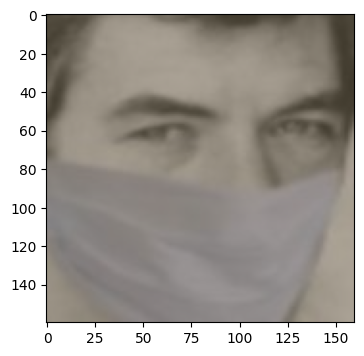

3 nearest images


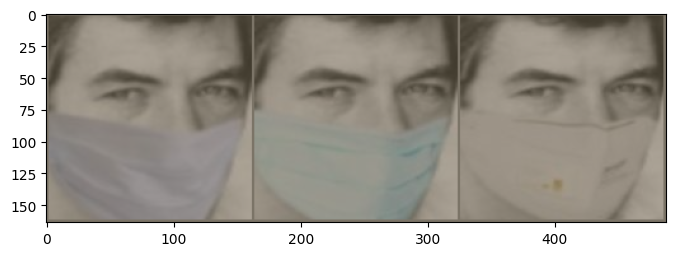


Query Image:1


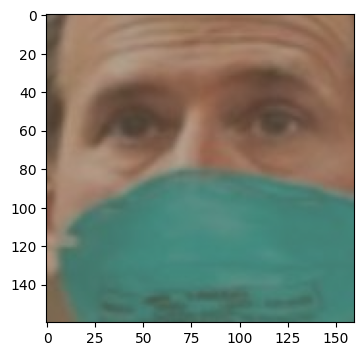

3 nearest images


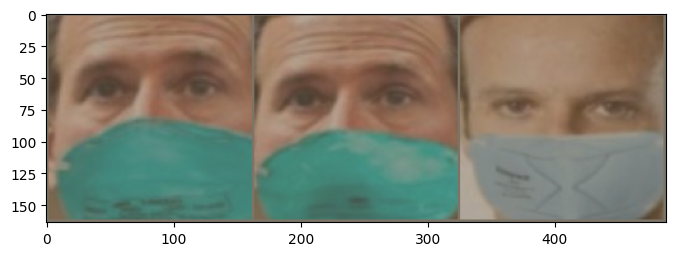


Query Image:2


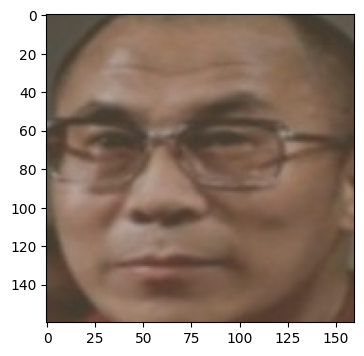

3 nearest images


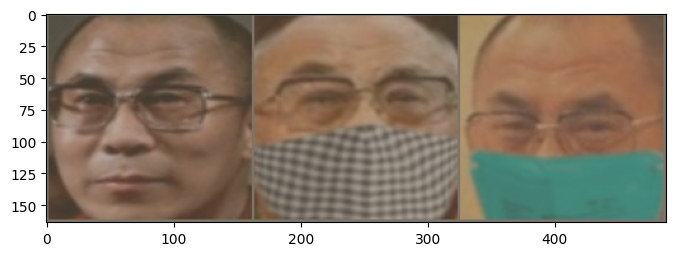


Query Image:3


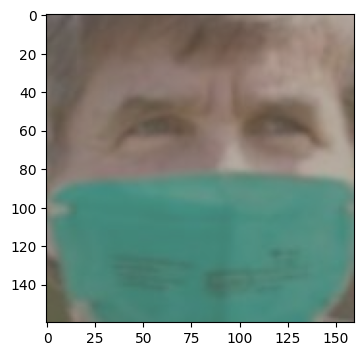

3 nearest images


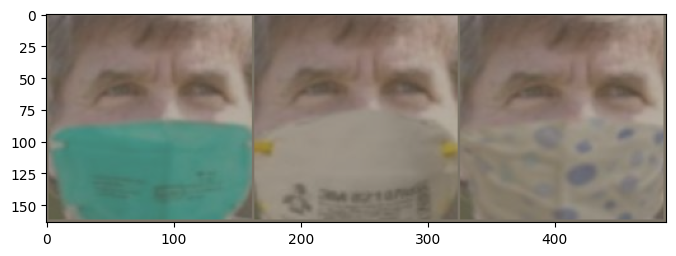


Query Image:4


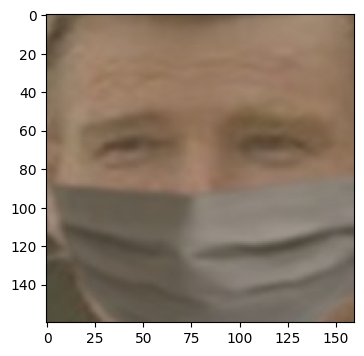

3 nearest images


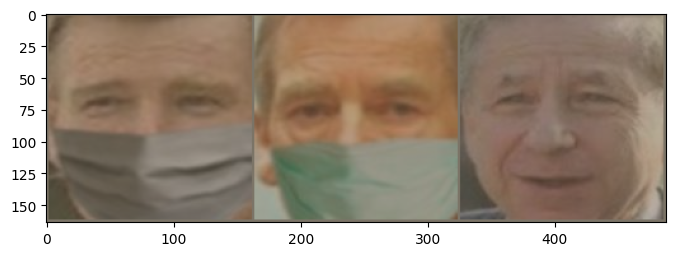


Query Image:5


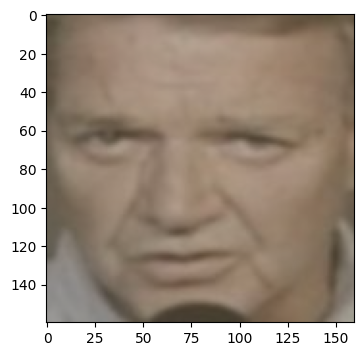

3 nearest images


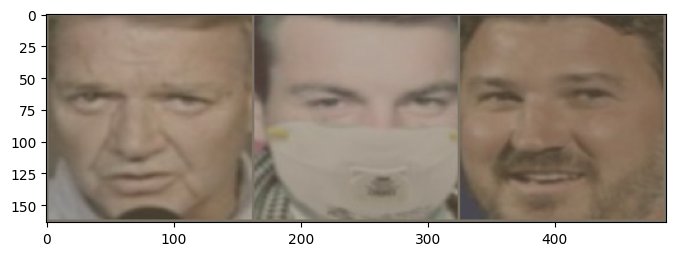


Query Image:6


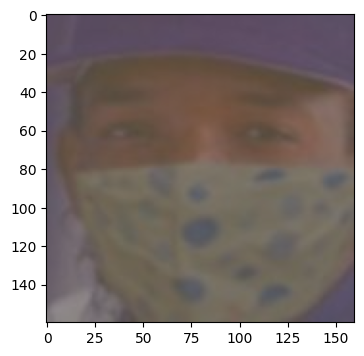

3 nearest images


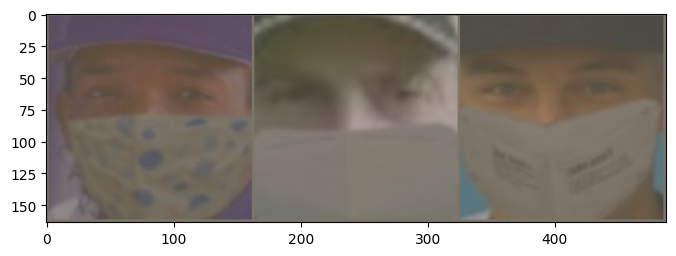


Query Image:7


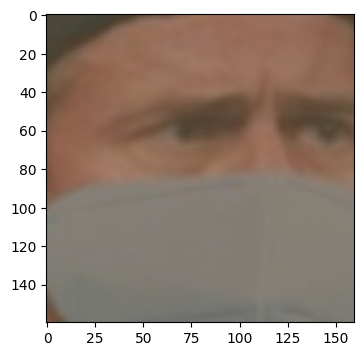

3 nearest images


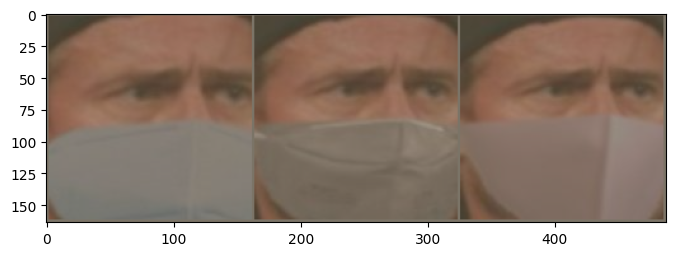


Query Image:8


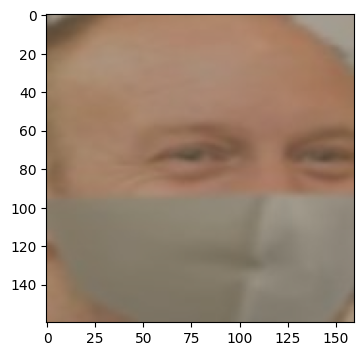

3 nearest images


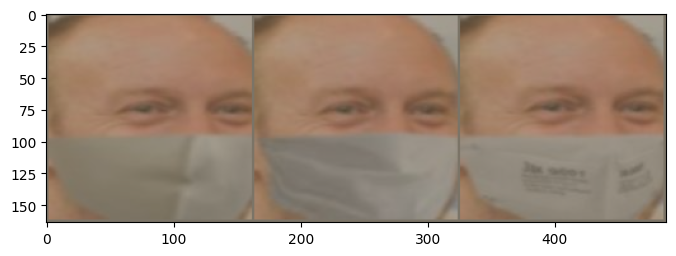


Query Image:9


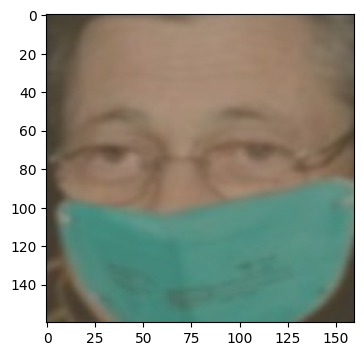

3 nearest images


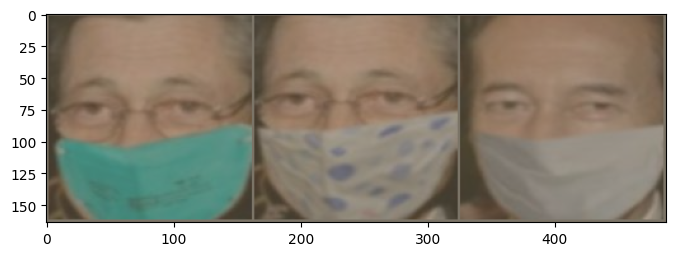

In [ ]:
for i in range(10):
  n=random.randint(0, len(dataset))
  img=dataset[n][0]
  print('Query Image:{}'.format(i))
  imshow(torchvision.utils.make_grid(img))
  distances, indices = inference_model.get_nearest_neighbors(img.unsqueeze(0), k=3)
  nearest_imgs = [dataset[i][0] for i in indices.cpu()[0]]
  print("3 nearest images")
  imshow(torchvision.utils.make_grid(nearest_imgs))
  print()


### Obs: Em Casos Onde Temos Menos Que 3 Imagens Por Classe(Nome de Pessoa), Pode Ocorrer de a Correspondência Encontrada forem Pessoas Diferentes, Nesse Caso O Modelo Vai Procurar a Pessoa Mais Parecida No Dataset da Treino, Apesar Disso Nota-se Que O Modelo Está Bastante Generalizável, Apresentando Resultados Consistentes

## Compara 10 Imagens Aleatórias Da Mesma Pessoa

Comparação  1
Tom_Hanks
Imagem 1:


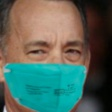

Imagem 2:


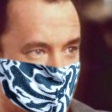

Similaridade do Cosseno Entre as Duas Imagens= 0.7554847598075867
Resultado da Comparação:
Mesma Pessoa

Comparação  2
Sean_Hayes
Imagem 1:


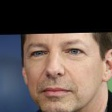

Imagem 2:


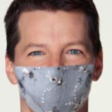

Similaridade do Cosseno Entre as Duas Imagens= 0.5011498332023621
Resultado da Comparação:
Pessoa Diferente

Comparação  3
Laura_Bush
Imagem 1:


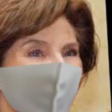

Imagem 2:


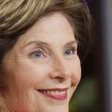

Similaridade do Cosseno Entre as Duas Imagens= 0.7822437882423401
Resultado da Comparação:
Mesma Pessoa

Comparação  4
Oswald_Gruebel
Imagem 1:


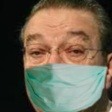

Imagem 2:


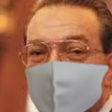

Similaridade do Cosseno Entre as Duas Imagens= 0.5638448596000671
Resultado da Comparação:
Pessoa Diferente

Comparação  5
Nicole
Imagem 1:


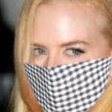

Imagem 2:


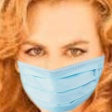

Similaridade do Cosseno Entre as Duas Imagens= 0.8855910301208496
Resultado da Comparação:
Mesma Pessoa

Comparação  6
Jamie_Lee_Curtis
Imagem 1:


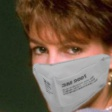

Imagem 2:


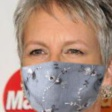

Similaridade do Cosseno Entre as Duas Imagens= 0.3716030716896057
Resultado da Comparação:
Pessoa Diferente

Comparação  7
Roger_Federer
Imagem 1:


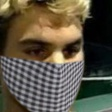

Imagem 2:


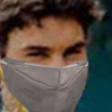

Similaridade do Cosseno Entre as Duas Imagens= 0.7802806496620178
Resultado da Comparação:
Mesma Pessoa

Comparação  8
Jennifer_McCoy
Imagem 1:


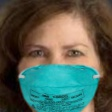

Imagem 2:


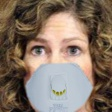

Similaridade do Cosseno Entre as Duas Imagens= 0.8425025939941406
Resultado da Comparação:
Mesma Pessoa

Comparação  9
Brian_Cook
Imagem 1:


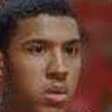

Imagem 2:


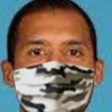

Similaridade do Cosseno Entre as Duas Imagens= 0.6567970514297485
Resultado da Comparação:
Mesma Pessoa

Comparação  10
Kaspar_Villiger
Imagem 1:


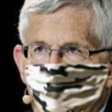

Imagem 2:


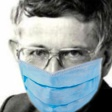

Similaridade do Cosseno Entre as Duas Imagens= 0.6184132099151611
Resultado da Comparação:
Mesma Pessoa



In [ ]:
i=0
while i<10:
  try:
    n=random.randint(0, len(os.listdir(train_data_path)))
    name=os.listdir(train_data_path)[n]
    if len(os.listdir(str(train_data_path)+'/'+name))>1:
      list_names=os.listdir(str(train_data_path)+'/'+name)
      path1=str(train_data_path)+'/'+name+'/'+list_names[0]
      path2=str(train_data_path)+'/'+name+'/'+list_names[1]
      img1=Image.open(path1)
      img2=Image.open(path2)
      img_cropped1 = mtcnn(img1)
      img_embedding1=inference_model.get_embeddings_from_tensor_or_dataset(img_cropped1,batch_size=1)
      #vector_desc1=img_embedding1.cpu().detach().numpy()
      img_cropped2 = mtcnn(img2)
      img_embedding2 = inference_model.get_embeddings_from_tensor_or_dataset(img_cropped2,batch_size=1)
      #vector_desc2=img_embedding2.cpu().detach().numpy()
      dist=float(distance(img_embedding1,img_embedding2)[0][0])
      if abs(dist)>0:
        print('Comparação ',i+1)
        print(name)
        print('Imagem 1:')
        display(img1)
        print('Imagem 2:')
        display(img2)
        print('Similaridade do Cosseno Entre as Duas Imagens=', dist)
        print('Resultado da Comparação:')
        show_decision(dist,thres=0.6)
        i=i+1
        print()
  except:
    pass

### Acertou 7 Imagens em 10, Acurácia de 70% Nessa Amostra

## Compara 10 Imagens Aleatórias De Pessoas Diferentes

Comparação  1
Imagem 1:
Frank_Pallone


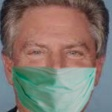

Imagem 2:
Jason_Alexander


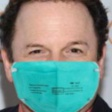

Similaridade do Cosseno Entre as Duas Imagens= 0.14086943864822388
Resultado da Comparação:
Pessoa Diferente

Comparação  2
Imagem 1:
Du_Qinglin


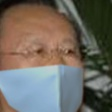

Imagem 2:
Terunobu_Maeda


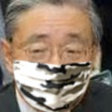

Similaridade do Cosseno Entre as Duas Imagens= -0.04748164117336273
Resultado da Comparação:
Pessoa Diferente

Comparação  3
Imagem 1:
Condoleezza_Rice


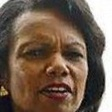

Imagem 2:
Rick_Barnes


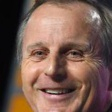

Similaridade do Cosseno Entre as Duas Imagens= -0.006835567764937878
Resultado da Comparação:
Pessoa Diferente

Comparação  4
Imagem 1:
Tom_Sizemore


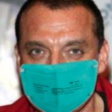

Imagem 2:
Ted_Williams


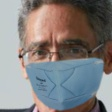

Similaridade do Cosseno Entre as Duas Imagens= 0.32288485765457153
Resultado da Comparação:
Pessoa Diferente

Comparação  5
Imagem 1:
Lars_Von_Trier


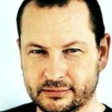

Imagem 2:
Al_Sharpton


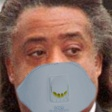

Similaridade do Cosseno Entre as Duas Imagens= 0.0839892104268074
Resultado da Comparação:
Pessoa Diferente

Comparação  6
Imagem 1:
Coleen_Rowley


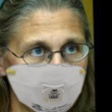

Imagem 2:
Omar_Vizquel


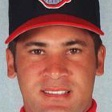

Similaridade do Cosseno Entre as Duas Imagens= 0.06285186111927032
Resultado da Comparação:
Pessoa Diferente

Comparação  7
Imagem 1:
Patricia_Heaton


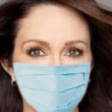

Imagem 2:
Lloyd_Ward


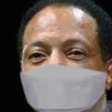

Similaridade do Cosseno Entre as Duas Imagens= -0.16163866221904755
Resultado da Comparação:
Pessoa Diferente

Comparação  8
Imagem 1:
Julio_Iglesias_Jr


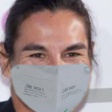

Imagem 2:
Jason_Petty


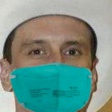

Similaridade do Cosseno Entre as Duas Imagens= 0.09039704501628876
Resultado da Comparação:
Pessoa Diferente

Comparação  9
Imagem 1:
Chea_Sophara


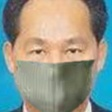

Imagem 2:
Guillaume_Depardieu


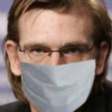

Similaridade do Cosseno Entre as Duas Imagens= -0.003974597901105881
Resultado da Comparação:
Pessoa Diferente

Comparação  10
Imagem 1:
Calbert_Cheaney


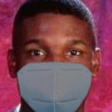

Imagem 2:
Terence_Newman


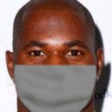

Similaridade do Cosseno Entre as Duas Imagens= 0.07066243886947632
Resultado da Comparação:
Pessoa Diferente



In [ ]:
i=0
while i<10:
  try:
    n=random.randint(0, len(os.listdir(train_data_path))-1)
    name1=os.listdir(train_data_path)[n]
    name2=os.listdir(train_data_path)[n+1]
    list_names1=os.listdir(str(train_data_path)+'/'+name1)
    list_names2=os.listdir(str(train_data_path)+'/'+name2)
    path1=str(train_data_path)+'/'+name1+'/'+list_names1[0]
    path2=str(train_data_path)+'/'+name2+'/'+list_names2[1]
    img1=Image.open(path1)
    img2=Image.open(path2)
    img_cropped1 = mtcnn(img1)
    img_embedding1=inference_model.get_embeddings_from_tensor_or_dataset(img_cropped1,batch_size=1)
    #vector_desc1=img_embedding1.cpu().detach().numpy()
    img_cropped2 = mtcnn(img2)
    img_embedding2 = inference_model.get_embeddings_from_tensor_or_dataset(img_cropped2,batch_size=1)
    #vector_desc2=img_embedding2.cpu().detach().numpy()
    dist=float(distance(img_embedding1,img_embedding2)[0][0])
    if abs(dist)>0:
      print('Comparação ',i+1)
      print('Imagem 1:')
      print(name1)
      display(img1)
      print('Imagem 2:')
      print(name2)
      display(img2)
      print('Similaridade do Cosseno Entre as Duas Imagens=', dist)
      print('Resultado da Comparação:')
      show_decision(dist,thres=0.6)
      i=i+1
      print()
  except:
    pass

### Acertou Todas!!! Acurácia de 100% Nesta Amostra, Outro Ponto Interessante é Que Aparentemente o Modelo Está Mais Propenso a Gerar Falsos Negativos, ou Seja, o Modelo Possui a Tendência de Dizer Que São Pessoas Diferentes, Quando Na Verdade São a Mesma Pessoa, Considerando Uma Aplicação de Segurança, Essa é Uma Caracteristica Positiva, Pois é Melhor um Falso Negativo do Que um Falso Positivo

## Compara As Duas Fotos de Teste, da Inferência e do DB, ou Seja do Marcelo Com e Sem Máscara Para Verificar Se Correspondem, Lembrando Que Essas Imagens Não Foram Usadas Para Treinar O Modelo:

Imagem 1:


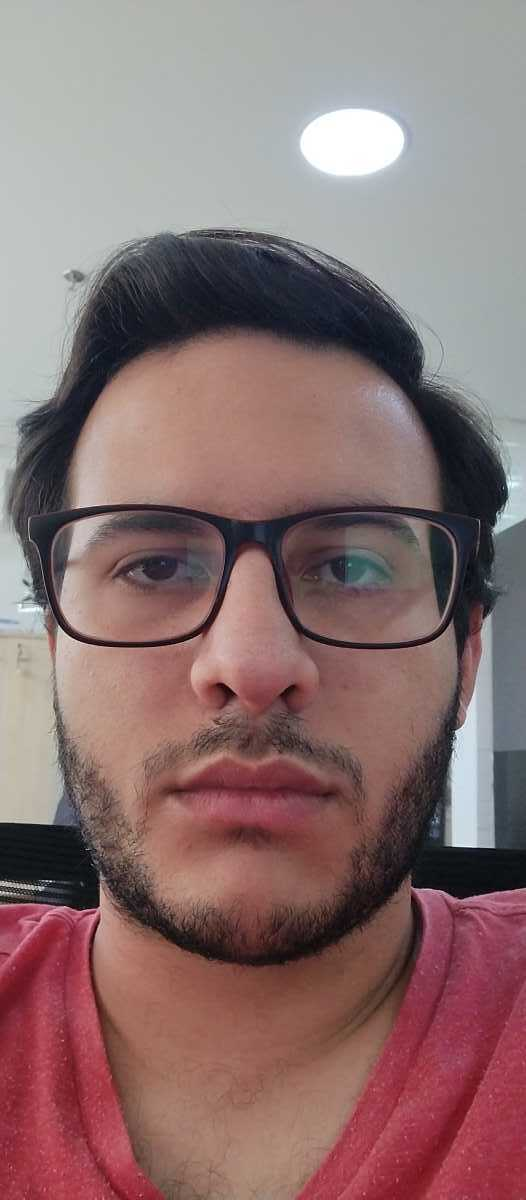

Imagem 2:


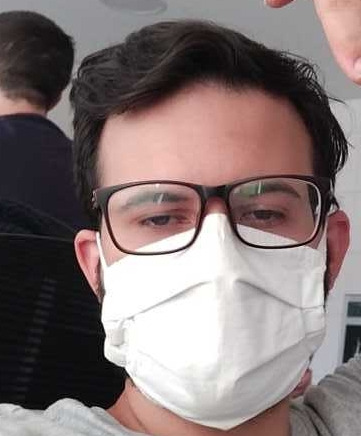

Similaridade do Cosseno Entre as Duas Imagens= 0.6203557252883911
Menor Distância Euclidiana Entre as Duas Imagens = 155.6328887939453
Resultado da Comparação:
Mesma Pessoa


In [ ]:
test_path=str(test_data_path)+'/Marcelo/'
min_dist=float("inf")

try:
  photo1=f'{test_path}/marcelinho_no_db.jpg'
  img1=Image.open(photo1)
  print('Imagem 1:')
  display(img1)
  img_cropped1 = mtcnn(img1)
  img_embedding1 = resnet(img_cropped1.unsqueeze(0)[0].cuda())
  vector_desc1=img_embedding1.cpu().detach().numpy()

  photo2=f'{test_path}/marcelinho_na_inferencia.jpg'
  img2=Image.open(photo2)
  print('Imagem 2:')
  display(img2)
  img_cropped2 = mtcnn(img2)
  img_embedding2 = resnet(img_cropped2.unsqueeze(0)[0].cuda())
  vector_desc2=img_embedding2.cpu().detach().numpy()

  dist=float(distance(img_embedding1,img_embedding2)[0][0])
  print('Similaridade do Cosseno Entre as Duas Imagens=', dist)
  _,cropped1=mtcnn.detect_box(img1)
  _,cropped2=mtcnn.detect_box(img2)
  for obj1 in cropped1:
    img_enc1=encode(obj1.unsqueeze(0).cuda())
    for obj2 in cropped2:
      img_enc2=encode(obj2.unsqueeze(0).cuda())
      dist2=float((img_enc1 - img_enc2).norm().item())
      if dist2<min_dist:
        min_dist=dist2
  print('Menor Distância Euclidiana Entre as Duas Imagens =', min_dist)
  print('Resultado da Comparação:')
  show_decision(dist,thres=0.6)

except Exception as e:
  print(e)

# Item 2) Cria o Banco de Dados e Salva Todas as Imagens no Banco Incluindo o Output do Vetor Descritor.
## Obs: Caso Queira Reproduzir Os Resultados desse Notebook e Não Precisar Inserir as Imagens Novamente no Banco, Pode Optar Por Executar a Célula Abaixo Para Carregar O Banco de Dados Já Criado Com as Imagens de Celebridades para Treino e a Foto do Marcelo Sem Máscara, e Pular Diretamente Para o Item 4

In [20]:
import sqlite3
import io

conn = sqlite3.connect('celebrities.db')
cursor = conn.cursor()
# Pode pular diretamente para o item 4 se não quiser salvar todas as imagens no banco novamente

In [ ]:
# deleta a tabela se existir para criar uma nova com os novos vetores descritores do modelo recem treinado
sqliteConnection = sqlite3.connect('celebrities.db')
cursor = sqliteConnection.cursor()
cursor.execute("DROP TABLE IF EXISTS famous_person;")
sqliteConnection.commit()
print("Tabela famous_person excluida com sucesso!")
cursor.close()

Tabela famous_person excluida com sucesso!


In [ ]:
#salva imagens no banco com o vetor descritor para cada imagem
cont=0
for folder in os.listdir(train_data_path):#obtem o nome do diretorio
  for name in os.listdir(str(train_data_path)+"/"+folder):
    try:
      photo=str(train_data_path)+"/"+folder+"/"+name
      img=Image.open(photo)
      img_cropped = mtcnn(img)
      #img_embedding = resnet(img_cropped.unsqueeze(0).cuda())
      img_embedding = resnet(img_cropped.cuda())
      vector_desc=img_embedding.cpu().detach().numpy()
      insertBLOB(photo,vector_desc)
    except Exception as e:
      print(e)
    torch.cuda.empty_cache()
    cont+=1

print("Finalizada a inserção das {} imagens no banco".format(cont))

A saída de streaming foi truncada nas últimas 5000 linhas.
Conectado a SQLite database celebridades
Imagem TrainDataset/Brad_Brownell/Brad_Brownell_0001_0000.jpg inserida com successo na tabela no BLOB
A conexão sqlite está fechada
Conectado a SQLite database celebridades
Imagem TrainDataset/Brad_Brownell/Brad_Brownell_0003_0000.jpg inserida com successo na tabela no BLOB
A conexão sqlite está fechada
Conectado a SQLite database celebridades
Imagem TrainDataset/Ron_Gonzales/Ron_Gonzales_0001_0000.jpg inserida com successo na tabela no BLOB
A conexão sqlite está fechada
Conectado a SQLite database celebridades
Imagem TrainDataset/Ron_Gonzales/Ron_Gonzales_0004_0000.jpg inserida com successo na tabela no BLOB
A conexão sqlite está fechada
Conectado a SQLite database celebridades
Imagem TrainDataset/Alfred_Sant/Alfred_Sant_0001_0000.jpg inserida com successo na tabela no BLOB
A conexão sqlite está fechada
Conectado a SQLite database celebridades
Imagem TrainDataset/Alfred_Sant/Alfred_Sant

## Item 3) Salva a Imagem do Marcelo Sem Máscara no Banco de Dados Com a Saída do Vetor Descritor

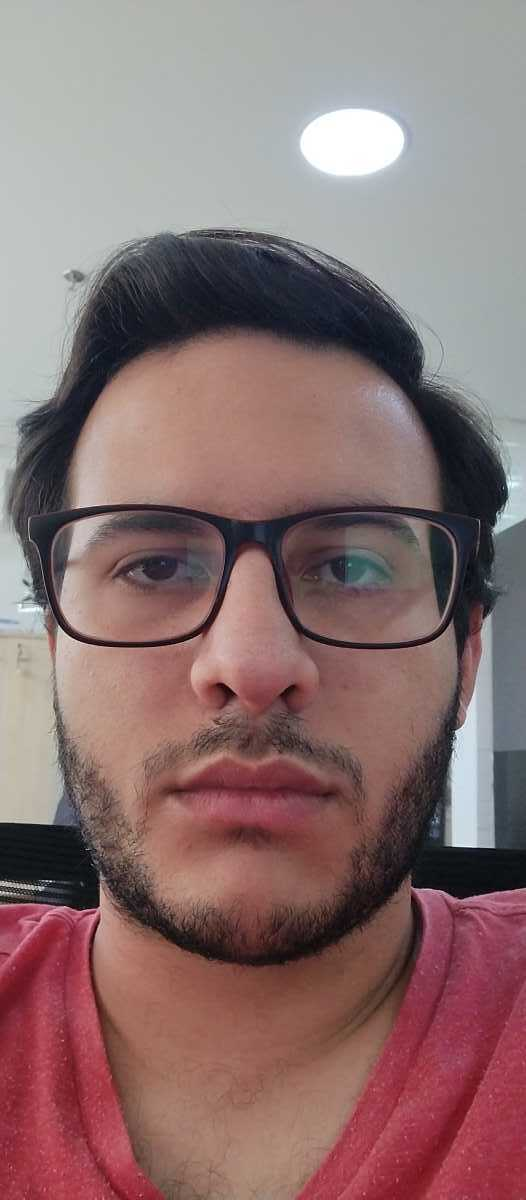

Conectado a SQLite database celebridades
Imagem TestDataset/Marcelo//marcelinho_no_db.jpg inserida com successo na tabela no BLOB
A conexão sqlite está fechada


In [ ]:
test_path=str(test_data_path)+'/Marcelo/'
try:
  photo=f'{test_path}/marcelinho_no_db.jpg'
  img=Image.open(photo)
  display(img)
  img_cropped = mtcnn(img)
  img_embedding = resnet(img_cropped.cuda())
  vector_desc=img_embedding.cpu().detach().numpy()
  insertBLOB(photo,vector_desc)
except Exception as e:
  print(e)
torch.cuda.empty_cache()

## Item 4) Reconhece a Imagen da Inferência no Banco de Dados, ou Seja do Marcelo Com Máscara, Comparando Com a Imagem Mais Similar Salva no Banco

Query Image:


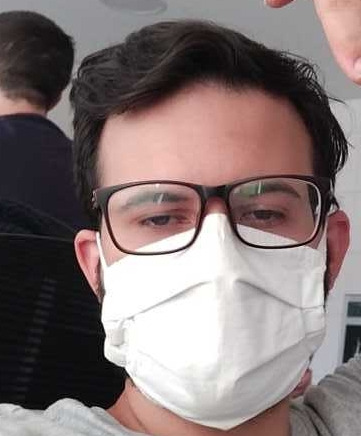

Consulta Concluida:
Resultados Encontrados Usando a Similaridade do Cosseno Entre as Duas Imagens Como Métrica de Distância:
A Correspondência Encontrada no Banco Foi: TestDataset/Marcelo//marcelinho_no_db.jpg e a Similaridade do Cosseno: 0.6203557252883911
Imagem Encontrada:


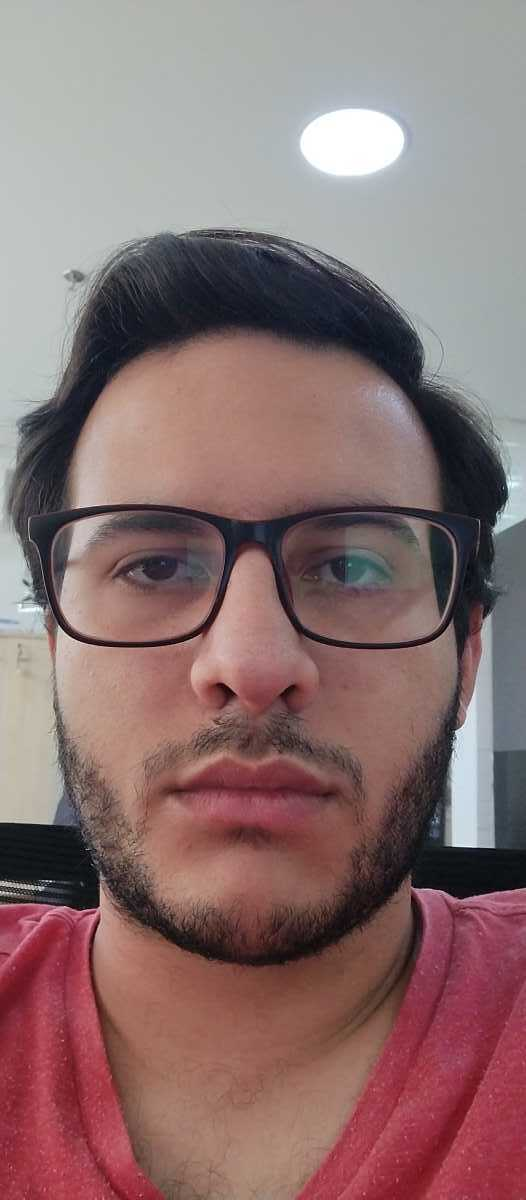


Resultados Encontrados Usando a Menor Distância Euclidiana Entre as Duas Imagens Como Métrica:
A Correspondência Encontrada no Banco Foi: TestDataset/Marcelo//marcelinho_no_db.jpg e a Menor Distância Euclidiana: 155.6328887939453
Imagem Encontrada:


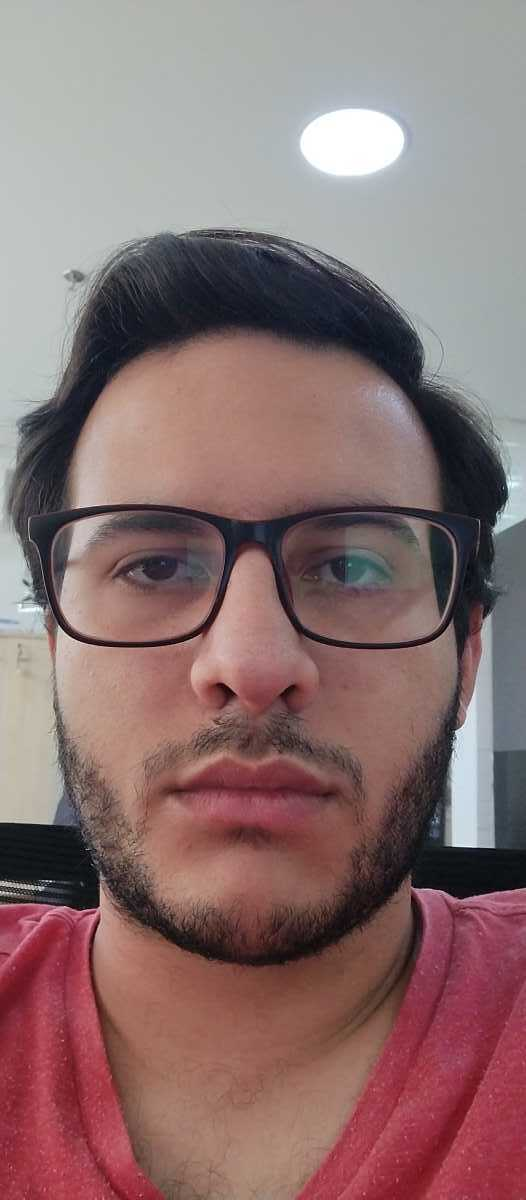

In [ ]:
max_dist=-float("inf")
match_img_name=None
match_img=None
min_dist=float("inf")
match_img_name2=None
match_img2=None

try:
  photo=f'{test_path}/marcelinho_na_inferencia.jpg'
  img=Image.open(photo)
  print('Query Image:')
  display(img)
  _,cropped=mtcnn.detect_box(img)
  img_cropped = mtcnn(img)
  img_embedding = resnet(img_cropped.cuda())
  sqliteConnection = sqlite3.connect('celebrities.db')
  cursor = sqliteConnection.cursor()
  for row in cursor.execute("SELECT path, photo, vector_des FROM famous_person;"):
    try:
      path, bytes_photo, vector_desc=row
      vector_desc=torch.frombuffer(vector_desc, dtype=torch.float32).unsqueeze(0).cuda()
      test_img = Image.open(io.BytesIO(bytes_photo))
      _,cropped2=mtcnn.detect_box(test_img)

      #metodo da similaridade do cosseno
      dist=float(distance(vector_desc,img_embedding)[0][0])
      if dist>max_dist:
        max_dist=dist
        match_img_name=path
        match_img=bytes_photo
      #método da menor distancia euclidiana
      for obj in cropped:
        img_enc1=encode(obj.unsqueeze(0).cuda())
        for obj2 in cropped2:
          img_enc2=encode(obj2.unsqueeze(0).cuda())
          dist2=float((img_enc1 - img_enc2).norm().item())
          if dist2<min_dist:
            min_dist=dist2
            match_img_name2=path
            match_img2=bytes_photo
    except Exception as e:
      continue
  cursor.close()
except Exception as e:
  print(e)
  torch.cuda.empty_cache()
print("Consulta Concluida:")
print("Resultados Encontrados Usando a Similaridade do Cosseno Entre as Duas Imagens Como Métrica de Distância:")
print('A Correspondência Encontrada no Banco Foi: {} e a Similaridade do Cosseno: {}'.format(match_img_name,max_dist))
print("Imagem Encontrada:")
display(Image.open(io.BytesIO(match_img)))
print()
print("Resultados Encontrados Usando a Menor Distância Euclidiana Entre as Duas Imagens Como Métrica:")
print('A Correspondência Encontrada no Banco Foi: {} e a Menor Distância Euclidiana: {}'.format(match_img_name2,min_dist))
print("Imagem Encontrada:")
display(Image.open(io.BytesIO(match_img2)))

# Conclusão:
## Além de o Modelo Ter Apresentado um Bom Desempenho Durante a Etapa de Treinamento, Ainda Conseguiu Perfeitamente Solucionar o Problema Proposto Nessa Questão, Pois Conseguiu Identificar Corretamente no Banco de Dados a Pessoa da Inferência, Encontrando a Correspondência Exata Através de Duas Métricas Diferentes: a Similaridade do Cosseno e a Menor Distância Euclidiana, Comparando as Imagens Do Marcelo Com e Sem Máscara, Sem Que Houvesse a Necessidade de Treinar o Modelo Novamente, Pois Essas Imagens Não Foram Usados Durante o Treinamento Reforçando a Hipótese de Que o Modelo Está Bastante Generalizável.
### Obs: Para Atingir Esse Resultado, Os Hyper-Parâmetros Foram Ajustados Experimentalmente Através de Testes.
### Outro Ponto Importante é que o Modelo Possui Uma Tendência Maior de Gerar Falsos Negativos, Ou Seja de Dizer que Duas Imagens não São da Mesma Pessoa, Quando na Verdade São, Considerando que Essa Seja Uma Aplicação Voltada Para Segurança, Essa é uma Carácterística Positiva, Pois Nesse Caso é Melhor Um Falso Negativo do Que Um Falso Positivo